## Comparison of GloGEM and PyGEM RGI 11 Runoff Outputs 

### Aggregation of GloGEM runoff:

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import os

## Generic the filepath to the main data folder
fpath0 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/GloGEM Outputs/CentralEurope/files/'  
fpath1 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/GloGEM Outputs/Runoff-intercomparison/GloGEM/Volume' 

#All of the climate models used
modelnames = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0']

SSPpaths = ['ssp126','ssp245','ssp370','ssp585']   #Specifiying the SSP
SSPs = ['ssp119','ssp126','ssp245','ssp370','ssp585'] #Use a different path as we have all 5 ssps for volume

In [127]:
all_discharges = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_discharges = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname + '/' + SSPpaths[s]  + '/' + 'centraleurope_Discharge_r1.dat', sep='\s+', header=None, skiprows=1, index_col=0)
        model_discharges.append(temp_df)
    all_discharges[s] = model_discharges

In [128]:
all_areas = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_areas = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname  + '/' + SSPpaths[s]  + '/' + 'centraleurope_Area_r1.dat', sep='\s+', index_col="ID")
        model_areas.append(temp_df)
    all_areas[s] = model_areas

In [129]:
# Create new index using pandas date_range function
start_date = datetime.date(1979, 10, 1)
end_date = datetime.date(2100, 9, 1)
new_indices = pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m').tolist()

# Apply new index and datetime conversion
for s, SSPpath_discharges in enumerate(all_discharges):
    for m, discharge_df in enumerate(SSPpath_discharges):
        all_discharges[s][m].columns = new_indices
        all_discharges[s][m].columns = pd.to_datetime(new_indices)

In [130]:
#expanding area dataset to match year-month dimension
for s in range(len(SSPpaths)):
    for i in range(len(all_areas[s])):
        all_areas[s][i] = all_areas[s][i][all_areas[s][i].columns.repeat(12)]
        
for s, areas in enumerate(all_areas):
    for i, area in enumerate(areas):
        all_areas[s][i].columns = new_indices
        all_areas[s][i].columns = pd.to_datetime(new_indices)

In [131]:
# We will use our initial area to compute runoff so we fill entire dfs with element 0
# We only use one SSP because the initial areas are all the same -- we save time without looping through all
# We also convert km^2 to m^2

initial_areas = [pd.DataFrame(df.iloc[:, 0].values.repeat(df.shape[1]).reshape(df.shape), index=df.index, columns=df.columns).mul(1e6) for df in all_areas[0]]

In [132]:
runoff = {s: {m: None for m in modelnames} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
n=0
for s in SSPpaths:
    i=0
    for m in modelnames:
        runoff[s][m] = pd.concat([initial_areas[i] * all_discharges[n][i]], axis=1)
        i+=1
    n+=1

In [133]:
import itertools
annualrunoff = {s: {m: None for m in modelnames} for s in SSPpaths}
for s, m in itertools.product(SSPpaths, modelnames):
    annualrunoff[s][m] = runoff[s][m].transpose().resample('A').sum()

In [134]:
import json
def select_glaciers_json(basin='all'):
    '''
    Select glaciers within a basin by MRBID from a json-file,
    which is stored in the data directory.

    Args:
    -----
    basin: str
        String of MRBID or 'all'.

    Returns:
    --------
    If basin is 'all' a list of all relevant glaciers is returned, for
    initiating glacier simulations. If basin is a MRBID the list of glaciers
    within that basin is returned.
    
    Copy of a function written by Erik Holmgren (2022) in holmgren_gha.utils
    '''

    # fpath = './data/rgi_ids_per_basin.json'
    fpath = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/rgi_ids_per_basin.json'  
    with open(fpath) as f:
        basin_dict = json.load(f)

    if basin.lower() != 'all':
        glacier_list = basin_dict[basin]
    else:
        glacier_list = list(itertools.chain.from_iterable(basin_dict.values()))

    return glacier_list

In [135]:
def sum_basin(basin_RGI_list, runoff_data):
    # Create new list to match our RGI formatting
    new_basin_list = [int(str(x)[-4:]) for x in basin_RGI_list]
    runoff_data = runoff_data.transpose()
    
    #TODO: create list of glaciers not included in GloGEM output
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_basin_list = [x for x in new_basin_list if x in runoff_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = runoff_data.loc[new_basin_list].copy()
    
    # Sum the values of the glaciers within the basin
    summed_basin_runoff = new_df.sum()
    #print(summed_basin_runoff)
    
    return summed_basin_runoff

In [136]:
#Generating the aggregated basin data
alpine_basins = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202'} ## GRDC Major River Basin identifiers for the 3 alpine basins we can study
modelnames_glo = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0']

Rhone_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
Rhine_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 
Po_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths}
Danube_runoff = {s: {m: None for m in modelnames_glo} for s in SSPpaths} 

for s in SSPpaths:
    for m in modelnames_glo:
        Rhine_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['RHINE']), annualrunoff[s][m])*1e-9    #m^3 to km^3
        Rhone_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['RHONE']), annualrunoff[s][m])*1e-9
        Po_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['PO']), annualrunoff[s][m])*1e-9
        Danube_runoff[s][m] = sum_basin(select_glaciers_json(alpine_basins['DANUBE']), annualrunoff[s][m])*1e-9

        
rm_Rhone = {s: {m: Rhone_runoff[s][m].rolling(30).mean() for m in modelnames_glo} for s in SSPpaths}
rm_Rhine = {s: {m: Rhine_runoff[s][m].rolling(30).mean() for m in modelnames_glo} for s in SSPpaths}
rm_Po = {s: {m: Po_runoff[s][m].rolling(30).mean() for m in modelnames_glo} for s in SSPpaths}
rm_Danube = {s: {m: Danube_runoff[s][m].rolling(30).mean() for m in modelnames_glo} for s in SSPpaths}

In [213]:
#To calculate multi GCM means and Quartiles we convert to df
#Will make this more efficient by looping through basins
basins = ['RHINE', 'RHONE', 'PO','DANUBE']

Rhone_mean = {}
Rhine_mean = {}
Po_mean = {}
Danube_mean = {}
for s in SSPpaths:
    Rhone_mean[s] = pd.DataFrame(Rhone_runoff[s]).mean(axis=1)
    Rhine_mean[s] = pd.DataFrame(Rhine_runoff[s]).mean(axis=1)
    Po_mean[s] = pd.DataFrame(Po_runoff[s]).mean(axis=1)
    Danube_mean[s] = pd.DataFrame(Danube_runoff[s]).mean(axis=1)

Rhone_q1 = {}
Rhine_mean = {}
Po_mean = {}
Danube_mean = {}

### Aggregation of PyGEM runoff:

In [143]:
import xarray as xr

#All of the climate models used
modelnames_py = ['BCC-CSM2-MR','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #List of all SSPs in PyGEM
which_ssp = SSPs[0]

alpine_basins = {'RHINE': '6242',
                 'RHONE': '6243',
                 'PO': '6241',
                 'DANUBE':'6202'} ## GRDC Major River Basin identifiers for the 4 alpine basins we can study

test_basin = alpine_basins['RHONE'] 

#Generic filepath to navigate to Drive folder 
fpath0 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff'

In [13]:
basin_gls = {}
for basin, code in alpine_basins.items():
    basin_gls[basin] = select_glaciers_json(code)

In [14]:
#Based upon code developed by Lizz Ultee
batches = ['1-1000.nc', '1001-2000.nc', '2001-3000.nc', '3001-4000.nc']

basin_datasets = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    basin_datasets[which_ssp] = {}  # Initialize basin_datasets with the ssp key
    
    fpath1 = '/11/R11_runoff_monthly_c2_ba1_1set_2000_2100-{}-Batch-'.format(which_ssp)

    for basin, glacier_list in basin_gls.items():
        ## loop over them all, drop the irrelevant IDs, and concatenate the result
        ds_list = []
        for b in batches:
            ds_temp = xr.open_dataset(fpath0 + fpath1 + b)
            try:
                ds_filtered = ds_temp.where(ds_temp.RGIId.isin(glacier_list), drop=True)
                ds_list.append(ds_filtered)
            except ValueError: ## happens if there are no glaciers from this batch in the selected region
                continue
        basin_datasets[which_ssp][basin] = xr.concat(ds_list, dim='glacier')

In [144]:
#Now we convert each basin ds to an annual format. Also convert m^3 to km^3
basins = ['RHINE', 'RHONE', 'PO','DANUBE']
annual_basin_ds = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    annual_basin_ds[which_ssp] = {}
    for basin in basins:
        annual_basin_ds[SSP][basin] = basin_datasets[SSP][basin].glac_runoff_monthly.resample(time='A').sum()*1e-9

In [62]:
#Calculating the sum of each basin
basin_sums_py = {}
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    basin_sums_py[which_ssp] = {}
    for basin in basins:
        basin_sums_py[which_ssp][basin] = annual_basin_ds[SSP][basin].sum(dim='glacier')

In [73]:
#Compute multi GCM means and quartiles
GCM_mean_py = {}
GCM_q1_py = {}
GCM_q3_py = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_mean_py[which_ssp] = {}
    GCM_q1_py[which_ssp] = {}
    GCM_q3_py[which_ssp] = {}
    for basin in basins:
        GCM_mean_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].mean(dim = 'model')
        GCM_q1_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3_py[which_ssp][basin] = basin_sums_py[which_ssp][basin].quantile(q = 0.75, dim = 'model')

Text(-1.43, 4.72, 'Rhine River Basin                   Rhone River Basin                      Po River Basin                   Danube River Basin')

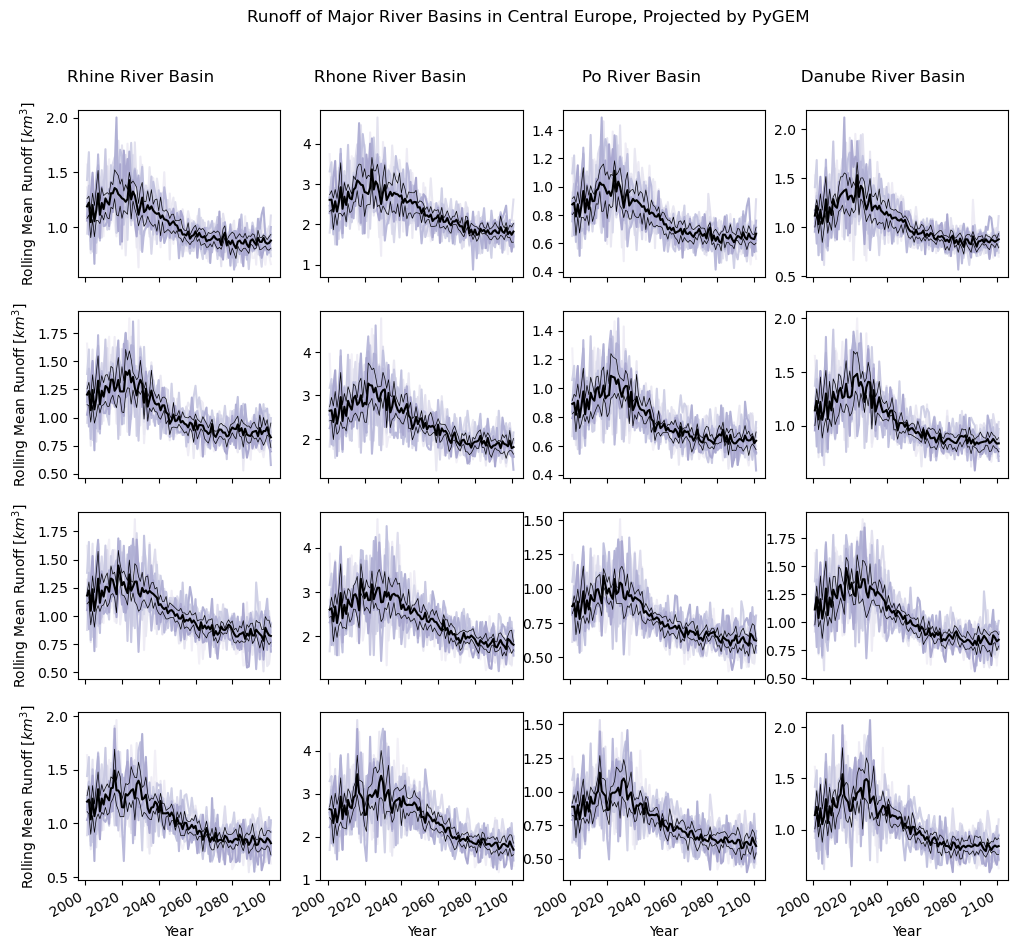

In [211]:
from cycler import cycler
scenarios = ['ssp126','ssp245','ssp370','ssp585']
time = np.linspace(2000, 2100, num =101)
time1 = pd.to_datetime(time)

colors_glo =  plt.colormaps['Greens']
line_colors_glo = np.linspace(0.2, 1, num = 12)

colors_py =  plt.colormaps['Purples']
line_colors_py = colors_py(np.linspace(0.1,.45,num = 12))
py_cycler = cycler(color = line_colors_py)

#Plotting all data
fig, axs = plt.subplots(len(scenarios), 4, figsize=(12, 10), sharex=True)
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):
        #basin_sums_py[which_ssp][basin].rolling(time=30).mean().plot(hue='model', ax=axs[s, b], color=axs[s, b].set_prop_cycle(py_cycler), add_legend=False)
        #GCM_mean_py[which_ssp][basin].rolling(time=30).mean().plot(hue='model', ax=axs[s, b], color = 'black', add_legend=False)
        #GCM_q1_py[which_ssp][basin].rolling(time=30).mean().plot(hue='model', ax=axs[s, b], color = 'black', linewidth = 0.5, add_legend=False)
        #GCM_q3_py[which_ssp][basin].rolling(time=30).mean().plot(hue='model', ax=axs[s, b], color = 'black', linewidth = 0.5, add_legend=False, label = False)

        basin_sums_py[which_ssp][basin].plot(hue='model', ax=axs[s, b], color=axs[s, b].set_prop_cycle(py_cycler), add_legend=False)
        GCM_mean_py[which_ssp][basin].plot(hue='model', ax=axs[s, b], color = 'black', add_legend=False)
        GCM_q1_py[which_ssp][basin].plot(hue='model', ax=axs[s, b], color = 'black', linewidth = 0.5, add_legend=False)
        GCM_q3_py[which_ssp][basin].plot(hue='model', ax=axs[s, b], color = 'black', linewidth = 0.5, add_legend=False)
        #axs[s,b].fill_between(time1, GCM_q1_py[which_ssp][basin], GCM_q3_py[which_ssp][basin], color = 'Purple')
        axs[s,b].set(title = '')
        
        if s == 3:
            for sub_b in range(4):  # Use a different variable name for the inner loop
                axs[s, sub_b].set_xlabel('Year')
        else:
            axs[s, b].set_xlabel(None)
        if b == 0:
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[sub_s, b].set_ylabel(r'Rolling Mean Runoff $[km^3]$')
        else:
            axs[s, b].set_ylabel(None)

plt.suptitle('Runoff of Major River Basins in Central Europe, Projected by PyGEM')
plt.title('Rhine River Basin                   Rhone River Basin                      Po River Basin                   Danube River Basin', x=-1.43, y=4.72)